In [1]:
!pip install datasets
#pip install ipywidgets
#!pip install wordcloud
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datasets import load_dataset
from wordcloud import WordCloud
import numpy as np

In [2]:
"""This section loads three sarcasm and sentiment datasets from Hugging Face and converts them into Pandas DataFrames
for easier data manipulation and analysis.
"""
ds_reddit = load_dataset("mindhunter23/BESSTIE-reddit-sarcasm-au")
ds_sentiment = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")
ds_news = load_dataset("raquiba/Sarcasm_News_Headline")
df_news = ds_news['train'].to_pandas()
df_sent = ds_sentiment['train'].to_pandas()
df_reddit = ds_reddit['train'].to_pandas()

Repo card metadata block was not found. Setting CardData to empty.


In [3]:
print("Reddit Sarcasm Dataset:")
print(df_reddit.columns)
print(df_reddit.head())

print("\n Sentiment Dataset:")
print(df_sent.columns)
print(df_sent.head())

print("\n News Headline Dataset:")
print(df_news.columns)
print(df_news.head())

Reddit Sarcasm Dataset:
Index(['id', 'text', 'sarcasm_label'], dtype='object')
        id                                               text  sarcasm_label
0  1d5cns8  This is very helpful, thankyou so much for you...              0
1  1d5fqvb  It's all about me. Something happens which is ...              1
2  1d1b31z  The Conversation: [‘Everybody has not won’: tr...              0
3  1cp6js4  >Hume said the force respected the public inte...              1
4  1d35ec2  He’s the last gasp of what LNP used to be, not...              1

 Sentiment Dataset:
Index(['id', 'text', 'label', 'sentiment'], dtype='object')
      id                                               text  label sentiment
0   9536                    Cooking microwave pizzas, yummy      2  positive
1   6135  Any plans of allowing sub tasks to show up in ...      1   neutral
2  17697   I love the humor, I just reworded it. Like sa...      2  positive
3  14182                       naw idk what ur talkin about      1   n

In [4]:
"""
This section standardizes the three datasets by filtering and renaming columns
so that all of them share the same structure with columns text, sentiment, and sarcasm.
Missing labels are filled with NaN or None to indicate that a particular task
(sentiment or sarcasm) is not applicable for that dataset.
"""
df_sent = df_sent[df_sent.columns.drop_duplicates()]
print("Sentiment dataset columns after dropping duplicates:", df_sent.columns.tolist())
print("Sentiment value counts (raw):")
print(df_sent["sentiment"].value_counts(), "\n")
df_sent_filtered = df_sent[df_sent["sentiment"].isin(["positive", "negative"])].copy()
df_sent_filtered = df_sent_filtered[["text", "sentiment"]].copy()
df_sent_filtered["sarcasm"] = np.nan
df_sent_filtered["sentiment"] = df_sent_filtered["sentiment"].map({"positive": 1, "negative": 0})
df_reddit = df_reddit.rename(columns={"sarcasm_label": "sarcasm"})
df_reddit = df_reddit[["text", "sarcasm"]].copy()
df_reddit["sentiment"] = np.nan
df_news = df_news.rename(columns={"headline": "text", "is_sarcastic": "sarcasm"})
df_news = df_news[["text", "sarcasm"]].copy()
df_news["sentiment"] = np.nan


Sentiment dataset columns after dropping duplicates: ['id', 'text', 'label', 'sentiment']
Sentiment value counts (raw):
sentiment
neutral     11649
positive    10478
negative     9105
Name: count, dtype: int64 



In [5]:
"""
This function standardizes text by removing URLs, HTML, and unwanted symbols,
replacing abbreviations, and cleaning up spacing and punctuation for better model input.
"""

def clean_text(text):
   text = str(text).lower()
   text = re.sub(r"http\S+|www\S+|https\S+", "", text)
   text = re.sub(r"<.*?>", "", text)
   abbreviations = {
        "u": "you", "r": "are", "idk": "i don't know", "lol": "laughing out loud",
        "btw": "by the way", "omg": "oh my god", "lmao": "laughing my ass off",
        "imo": "in my opinion", "im": "i am", "dont": "do not", "cant": "cannot",
        "wont": "will not", "ive": "i have", "ur": "your","wanna": "want to", "gonna": "going to",
        "ain't": "is not",
        "ya": "you"
    }
   for abbr, full in abbreviations.items():
        text = re.sub(r"\b" + re.escape(abbr) + r"\b", full, text)
   text = text.replace("’", "'").replace("‘", "'")
   text = text.replace("“", '"').replace("”", '"')
   text = text.replace("–", "-").replace("—", "-").replace("…", "...")
   text = re.sub(r"[^\x00-\x7F]+", "", text)
   punct_to_remove = string.punctuation.replace("'", "")
   for char in punct_to_remove:
      text = text.replace(char, "")
   text = re.sub(r"\s+", " ", text).strip()
   return text


In [6]:
print("Cleaning text for all datasets...\n")

df_sent_filtered["clean_text"] = df_sent_filtered["text"].apply(clean_text)
df_reddit["clean_text"] = df_reddit["text"].apply(clean_text)
df_news["clean_text"] = df_news["text"].apply(clean_text)

print(" Sentiment Dataset (Before & After Cleaning):")
print(df_sent_filtered[["text", "clean_text"]].head(), "\n")

print("Reddit Sarcasm Dataset (Before & After Cleaning):")
print(df_reddit[["text", "clean_text"]].head(), "\n")

print("News Headline Dataset (Before & After Cleaning):")
print(df_news[["text", "clean_text"]].head(), "\n")

Cleaning text for all datasets...

 Sentiment Dataset (Before & After Cleaning):
                                                text  \
0                    Cooking microwave pizzas, yummy   
2   I love the humor, I just reworded it. Like sa...   
4          That sucks to hear. I hate days like that   
5   Umm yeah. That`s probably a pretty good note ...   
7   That would panic me a little!  Maybe you can ...   

                                          clean_text  
0                     cooking microwave pizzas yummy  
2  i love the humor i just reworded it like sayin...  
4           that sucks to hear i hate days like that  
5  umm yeah thats probably a pretty good note to ...  
7  that would panic me a little maybe you can rea...   

Reddit Sarcasm Dataset (Before & After Cleaning):
                                                text  \
0  This is very helpful, thankyou so much for you...   
1  It's all about me. Something happens which is ...   
2  The Conversation: [‘Everybody

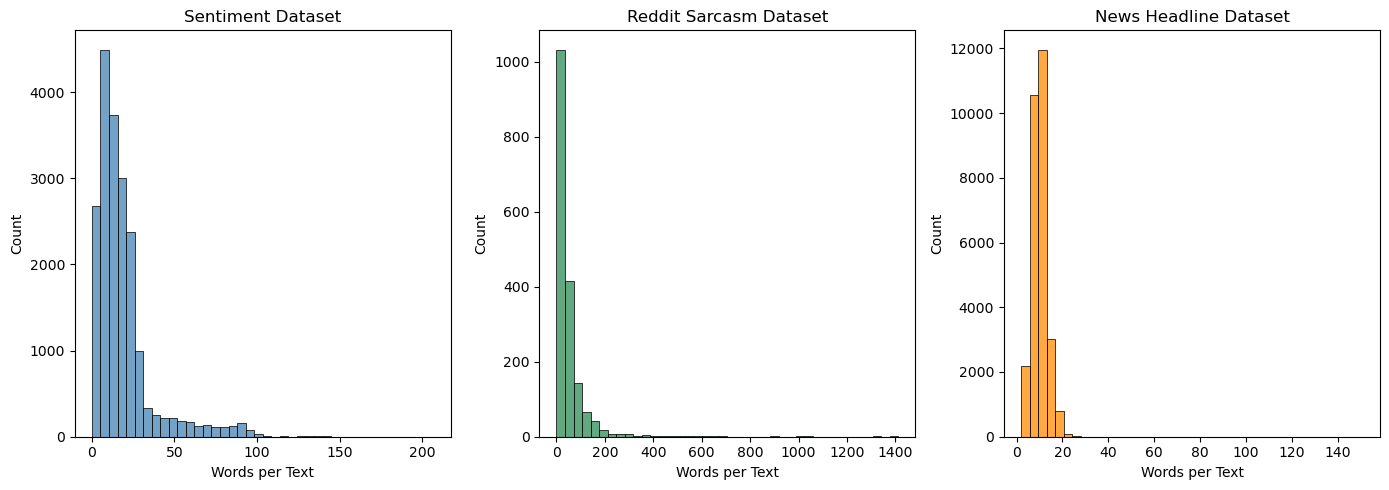

In [7]:
"""Count the number of words in each cleaned text and compare the text length distributions across the three datasets
using histograms.
"""

df_sent_filtered["word_count"] = df_sent_filtered["clean_text"].astype(str).apply(lambda x: len(x.split()))
df_reddit["word_count"] = df_reddit["clean_text"].astype(str).apply(lambda x: len(x.split()))
df_news["word_count"] = df_news["clean_text"].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.histplot(df_sent_filtered["word_count"], bins=40, color="steelblue", edgecolor="black")
plt.title("Sentiment Dataset")
plt.xlabel("Words per Text")

plt.subplot(1, 3, 2)
sns.histplot(df_reddit["word_count"], bins=40, color="seagreen", edgecolor="black")
plt.title("Reddit Sarcasm Dataset")
plt.xlabel("Words per Text")

plt.subplot(1, 3, 3)
sns.histplot(df_news["word_count"], bins=40, color="darkorange", edgecolor="black")
plt.title("News Headline Dataset")
plt.xlabel("Words per Text")

plt.tight_layout()
plt.show()



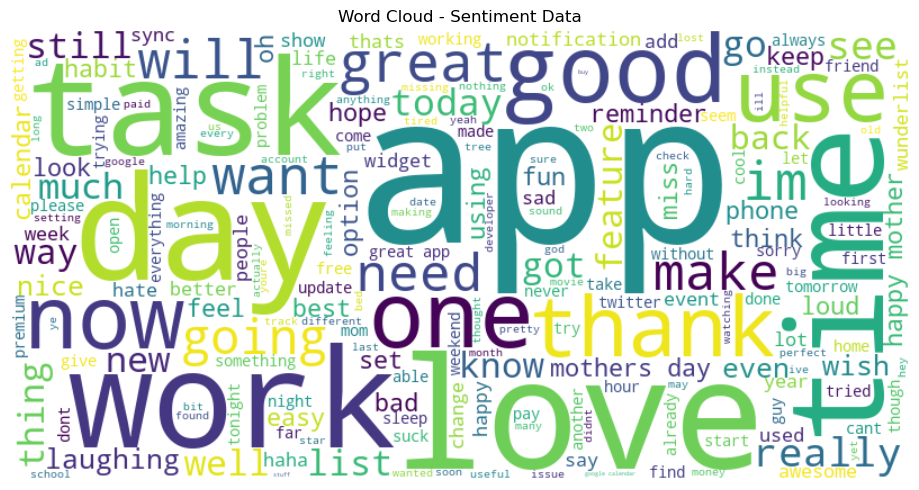

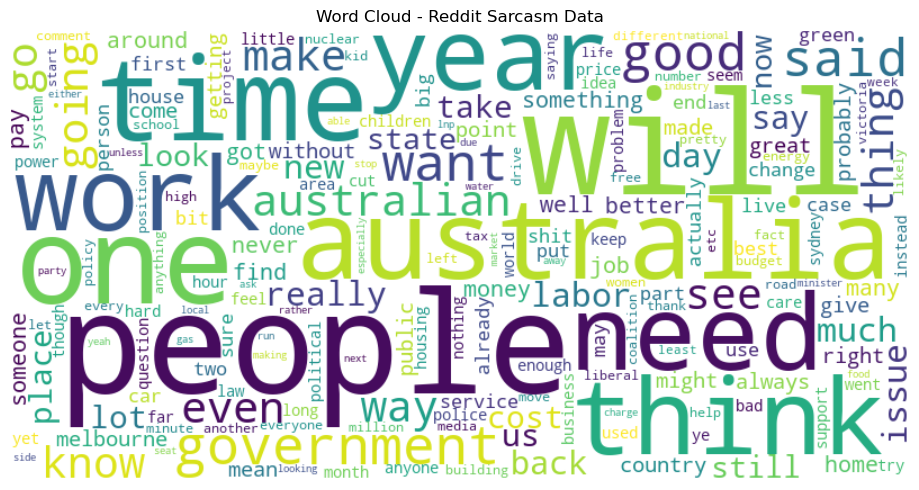

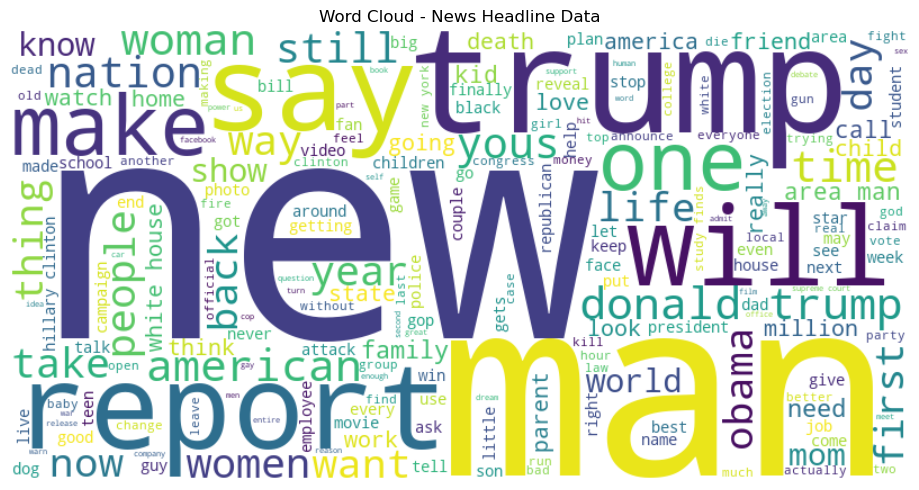

In [8]:
def plot_wordcloud(text_list, title):
    text = " ".join(text_list)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_wordcloud(df_sent_filtered["clean_text"].dropna().tolist(), "Word Cloud - Sentiment Data")
plot_wordcloud(df_reddit["clean_text"].dropna().tolist(), "Word Cloud - Reddit Sarcasm Data")
plot_wordcloud(df_news["clean_text"].dropna().tolist(), "Word Cloud - News Headline Data")

count    49693.000000
mean        13.995774
std         12.884515
min          1.000000
25%          8.000000
50%         11.000000
75%         15.000000
max        100.000000
Name: word_count, dtype: float64


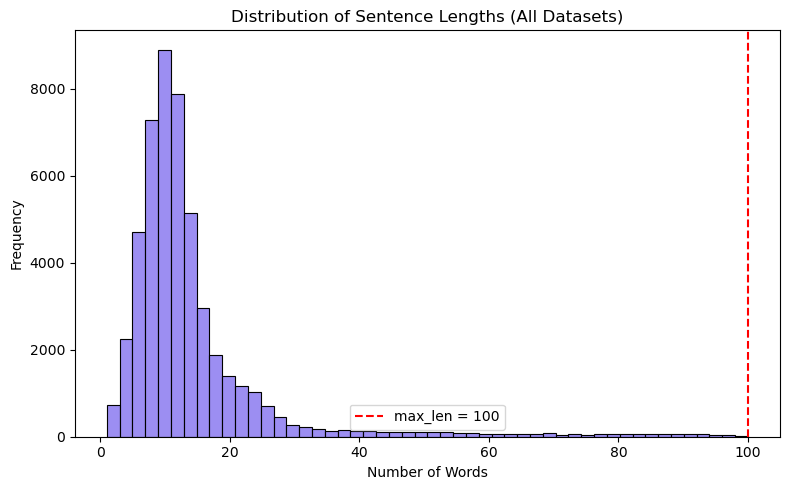

In [9]:
'''
Merge the datasets, keep only texts with 1–100 words, and plot how sentence lengths are distributed.
'''
MAX_LEN = 100
df_merged = pd.concat([df_sent_filtered, df_reddit, df_news], ignore_index=True)
df_merged = df_merged[df_merged["word_count"] > 0].copy()
df_merged = df_merged[df_merged["word_count"] <= MAX_LEN].copy()
print(df_merged["word_count"].describe())
plt.figure(figsize=(8, 5))
sns.histplot(df_merged["word_count"], bins=50, color="mediumslateblue", edgecolor="black")
plt.axvline(100, color="red", linestyle="--", label="max_len = 100")
plt.title("Distribution of Sentence Lengths (All Datasets)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
'''
This cell builds a vocabulary from the cleaned text, keeping words that appear at least twice.
It then defines functions to encode each sentence into a sequence of word indices and pad them to a fixed length.
Finally, it applies this processing to all cleaned texts and stores the resulting input ID sequences in a new column.
'''

import torch
from collections import Counter

def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = str(text).split()
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

def encode_text(text, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in text.split()]

def pad_sequence_to_length(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

vocab = build_vocab(df_merged["clean_text"], min_freq=2)

def process_text(text):
    encoded = encode_text(text, vocab)                     
    padded = pad_sequence_to_length(encoded, MAX_LEN)      
    return padded

df_merged["input_ids"] = df_merged["clean_text"].apply(process_text)

Vocabulary check
Vocabulary size: 21706
<PAD> in vocab: True
<UNK> in vocab: True
First 20 vocabulary entries:
 0: <PAD> → 0
 1: <UNK> → 1
 2: cooking → 2
 3: microwave → 3
 4: pizzas → 4
 5: yummy → 5
 6: i → 6
 7: love → 7
 8: the → 8
 9: humor → 9
10: just → 10
11: it → 11
12: like → 12
13: saying → 13
14: therapy' → 14
15: keeps → 15
16: my → 16
17: moms → 17
18: off → 18
19: back → 19
'love' in vocab: True
'the' in vocab: True
'zxcvbn' in vocab: False

Encoding check
Original cleaned text: cooking microwave pizzas yummy
Tokens: ['cooking', 'microwave', 'pizzas', 'yummy']
Encoded indices: [2, 3, 4, 5]

Padding check
Padded sequence lengths and their counts:
input_ids
100    49693
Name: count, dtype: int64

Example padded sequence (first 20 tokens):
[2, 3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Full padded length: 100


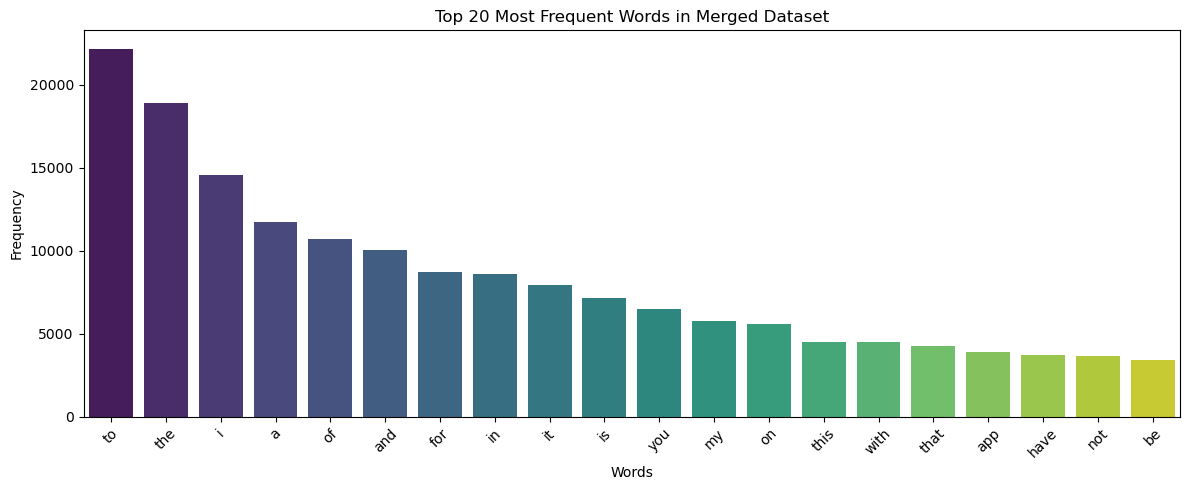

In [11]:
'''
This cell verifies the vocabulary, encoding, and padding steps by:
1) Printing vocabulary size and checking for key tokens.
2) Displaying the first few vocabulary entries.
3) Encoding and padding a sample sentence to inspect the result.
4) Checking the lengths of all padded sequences.
5) Visualizing the top 20 most frequent words in the merged dataset.
'''

print("Vocabulary check")
print("Vocabulary size:", len(vocab))
print("<PAD> in vocab:", "<PAD>" in vocab)
print("<UNK> in vocab:", "<UNK>" in vocab)


print("First 20 vocabulary entries:")
for i, (word, idx) in enumerate(vocab.items()):
    print(f"{i:>2}: {word} → {idx}")
    if i >= 19:
        break

print("'love' in vocab:", "love" in vocab)
print("'the' in vocab:", "the" in vocab)
print("'zxcvbn' in vocab:", "zxcvbn" in vocab)
print()

print("Encoding check")
i = 0
sample_text = df_merged.iloc[i]["clean_text"]
sample_tokens = sample_text.split()
sample_indices = encode_text(sample_text, vocab)

print("Original cleaned text:", sample_text)
print("Tokens:", sample_tokens)
print("Encoded indices:", sample_indices)
print()

print("Padding check")
length_counts = df_merged["input_ids"].apply(len).value_counts()
print("Padded sequence lengths and their counts:")
print(length_counts)

print("\nExample padded sequence (first 20 tokens):")
print(df_merged.iloc[i]["input_ids"][:20])
print("Full padded length:", len(df_merged.iloc[i]["input_ids"]))

word_counts = Counter()
for text in df_merged["clean_text"]:
    word_counts.update(text.split())

most_common_words = word_counts.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(words), y=list(counts), hue=list(words), palette="viridis", legend=False)
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Merged Dataset")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [103]:
'''
This cell sets key training hyperparameters and prepares the data for model input.
It converts input IDs and labels (sentiment and sarcasm) into PyTorch tensors,
replacing missing labels with -1 to support masking during training.
The dataset is then split into training (60%), validation (20%), and test (20%) sets,
while maintaining alignment between input features and both output labels.
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

num_epochs          = 10
batch_size          = 64
lr                  = 3e-4
embed_dim           = 128
hidden_dim          = 128
dropout             = 0.3
early_stop_patience = 1
weight_decay        = 1e-5

# construct tensors from df_merged
X_all = torch.tensor(df_merged["input_ids"].tolist(), dtype=torch.long)
sentiment_array = df_merged["sentiment"].apply(lambda x: -1 if pd.isna(x) else int(x)).values
sarcasm_array   = df_merged["sarcasm"].apply(lambda x: -1 if pd.isna(x) else float(x)).values
y_sent_all = torch.tensor(sentiment_array, dtype=torch.long)
y_sarc_all = torch.tensor(sarcasm_array,    dtype=torch.float)

print(f"Total samples: {len(X_all)}")
print(f"Sentiment-labeled: {(y_sent_all != -1).sum().item()}")
print(f"Sarcasm-labeled:   {(y_sarc_all != -1).sum().item()}")

# seperate train,validation and test set: 60:20:20
X_train, X_temp, y_sent_train, y_sent_temp, y_sarc_train, y_sarc_temp = train_test_split(
    X_all, y_sent_all, y_sarc_all,
    test_size=0.4,
    random_state=42,
    shuffle=True
)
X_val, X_test, y_sent_val, y_sent_test, y_sarc_val, y_sarc_test = train_test_split(
    X_temp, y_sent_temp, y_sarc_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("Train size:", X_train.shape[0])
print("Val size:  ", X_val.shape[0])
print("Test size: ", X_test.shape[0])


Total samples: 49693
Sentiment-labeled: 19497
Sarcasm-labeled:   30196
Train size: 29815
Val size:   9939
Test size:  9939


In [105]:
'''
This cell defines a multi-task BiLSTM model that predicts both sentiment (classification)
and sarcasm (binary) labels from text input. The model uses an embedding layer,
a two-layer bidirectional LSTM, and shared max-pooling followed by separate
output layers for each task. It also sets up the loss functions, optimizer (Adam),
and a learning rate scheduler that reduces the LR if the validation loss stops improving for a while.
'''

class AttentionPooling(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_outputs):  
        weights = self.attention(lstm_outputs).squeeze(-1)         
        weights = F.softmax(weights, dim=1)                        
        pooled = torch.sum(lstm_outputs * weights.unsqueeze(-1), dim=1) 
        return pooled
        
# write the LSTM model
class MultiTaskBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=2,
                            batch_first=True, bidirectional=True)
        self.att_pool = AttentionPooling(hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.sentiment_fc = nn.Linear(hidden_dim * 2, 2)
        self.sarcasm_fc   = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        embedded = self.embedding(x)         
        output, _ = self.lstm(embedded)     
        pooled = self.att_pool(output)      
        pooled = self.dropout(pooled)
        sentiment_logits = self.sentiment_fc(pooled) 
        sarcasm_logits   = self.sarcasm_fc(pooled)   
        return sentiment_logits, sarcasm_logits

# instantiate model, define loss and optimizer
vocab_size = len(vocab)
model = MultiTaskBiLSTM(vocab_size=vocab_size, embed_dim=embed_dim, hidden_dim=hidden_dim, dropout=dropout)
loss_sentiment = nn.CrossEntropyLoss()
loss_sarcasm   = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


Epoch 1/10
Train Loss: 1.2130 | Val Loss: 1.0131
Sentiment Loss -> Train: 0.6011 | Val: 0.4874
Sarcasm   Loss -> Train: 0.6119 | Val: 0.5257
Sentiment -> Acc: Train 0.651 | Val 0.758 | F1: 0.765 | Prec: 0.796 | Rec: 0.736
Sarcasm   -> Acc: Train 0.643 | Val 0.740 | F1: 0.738 | Prec: 0.709 | Rec: 0.770
Epoch 2/10
Train Loss: 0.9124 | Val Loss: 0.8915
Sentiment Loss -> Train: 0.4330 | Val: 0.4224
Sarcasm   Loss -> Train: 0.4794 | Val: 0.4691
Sentiment -> Acc: Train 0.798 | Val 0.803 | F1: 0.813 | Prec: 0.823 | Rec: 0.804
Sarcasm   -> Acc: Train 0.776 | Val 0.776 | F1: 0.761 | Prec: 0.771 | Rec: 0.751
Epoch 3/10
Train Loss: 0.7674 | Val Loss: 0.8413
Sentiment Loss -> Train: 0.3628 | Val: 0.3932
Sarcasm   Loss -> Train: 0.4046 | Val: 0.4480
Sentiment -> Acc: Train 0.840 | Val 0.815 | F1: 0.823 | Prec: 0.843 | Rec: 0.803
Sarcasm   -> Acc: Train 0.821 | Val 0.793 | F1: 0.784 | Prec: 0.779 | Rec: 0.789
Epoch 4/10
Train Loss: 0.6537 | Val Loss: 0.8272
Sentiment Loss -> Train: 0.2989 | Val: 0.3

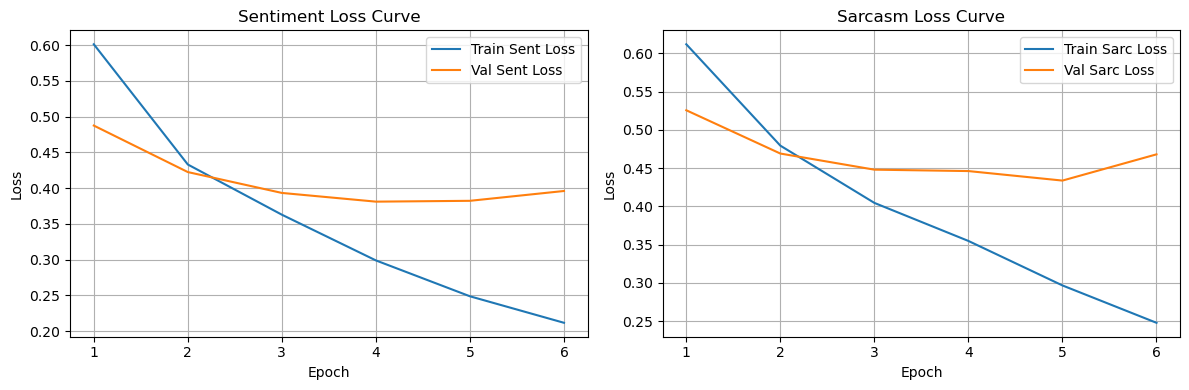

In [107]:
'''
This cell trains the multi-task BiLSTM model on both sentiment and sarcasm tasks.
It uses masking to skip missing labels, calculates task-specific losses and accuracy,
and applies early stopping when the validation loss stops improving.
The learning rate is adjusted using a scheduler if performance plateaus.
After training, it plots the training and validation loss curves for both tasks.
'''
# training 
train_sent_losses = []
train_sarc_losses = []
val_sent_losses   = []
val_sarc_losses   = []
train_total_losses = []
val_total_losses   = []

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_sent_loss_epoch = 0.0
    train_sarc_loss_epoch = 0.0
    train_batches = 0
    train_correct_sent = 0
    train_correct_sarc = 0
    train_total_sent   = 0
    train_total_sarc   = 0
    perm = torch.randperm(X_train.shape[0])
    
    for i in range(0, X_train.shape[0], batch_size):
        train_batches += 1
        indices = perm[i : i + batch_size]
        batch_input    = X_train[indices]
        batch_senlabel = y_sent_train[indices]
        batch_sarlabel = y_sarc_train[indices]
        pred_sen, pred_sar = model(batch_input)
        mask_sen = (batch_senlabel != -1)
        mask_sar = (batch_sarlabel != -1)
        loss_sent = torch.tensor(0.0)
        loss_sarc = torch.tensor(0.0)

        if mask_sen.sum() > 0:
            loss_sent = loss_sentiment(pred_sen[mask_sen], batch_senlabel[mask_sen])
            preds = pred_sen[mask_sen].argmax(dim=1)
            train_correct_sent += (preds == batch_senlabel[mask_sen]).sum().item()
            train_total_sent   += mask_sen.sum().item()
        
        if mask_sar.sum() > 0:
            loss_sarc = loss_sarcasm(pred_sar[mask_sar].view(-1), batch_sarlabel[mask_sar])
            probs = torch.sigmoid(pred_sar[mask_sar].view(-1))
            preds = (probs > 0.5).float()
            train_correct_sarc += (preds == batch_sarlabel[mask_sar]).sum().item()
            train_total_sarc   += mask_sar.sum().item()

        loss_total = loss_sent + loss_sarc
        optimizer.zero_grad()
        loss_total.backward()
        optimizer.step()
        train_sent_loss_epoch += loss_sent.item()
        train_sarc_loss_epoch += loss_sarc.item()
    
    train_sent_loss_epoch /= train_batches
    train_sarc_loss_epoch /= train_batches
    train_total_loss_epoch = train_sent_loss_epoch +  train_sarc_loss_epoch
    train_sent_losses.append(train_sent_loss_epoch)
    train_sarc_losses.append(train_sarc_loss_epoch)
    train_total_losses.append(train_total_loss_epoch)
    train_sen_acc = train_correct_sent / train_total_sent if train_total_sent > 0 else 0
    train_sar_acc = train_correct_sarc / train_total_sarc if train_total_sarc > 0 else 0

# validation 
    model.eval()
    val_sent_loss_epoch = 0.0
    val_sarc_loss_epoch = 0.0
    val_batches = 0
    val_correct_sent = 0
    val_correct_sarc = 0
    val_total_sent   = 0
    val_total_sarc   = 0
    all_sen_true = []
    all_sen_pred = []
    all_sar_true = []
    all_sar_pred = []

    with torch.no_grad():
        for i in range(0, X_val.shape[0], batch_size):
            val_batches += 1
            batch_input = X_val[i : i + batch_size]
            batch_senlabel = y_sent_val[i : i + batch_size]
            batch_sarlabel = y_sarc_val[i : i + batch_size]
            pred_sen, pred_sar = model(batch_input)
            mask_sen = (batch_senlabel != -1)
            mask_sar = (batch_sarlabel != -1)
            loss_sent = torch.tensor(0.0)
            loss_sarc = torch.tensor(0.0)

            if mask_sen.sum() > 0:
                loss_sent = loss_sentiment(pred_sen[mask_sen], batch_senlabel[mask_sen])
                preds = pred_sen[mask_sen].argmax(dim=1)
                val_correct_sent += (preds == batch_senlabel[mask_sen]).sum().item()
                val_total_sent   += mask_sen.sum().item()
                all_sen_true.extend(batch_senlabel[mask_sen].tolist())
                all_sen_pred.extend(preds.tolist())

            if mask_sar.sum() > 0:
                loss_sarc = loss_sarcasm(pred_sar[mask_sar].view(-1), batch_sarlabel[mask_sar])
                probs = torch.sigmoid(pred_sar[mask_sar].view(-1))
                preds = (probs > 0.5).float()
                val_correct_sarc += (preds == batch_sarlabel[mask_sar]).sum().item()
                val_total_sarc   += mask_sar.sum().item()
                all_sar_true.extend(batch_sarlabel[mask_sar].tolist())
                all_sar_pred.extend(preds.tolist())

            val_sent_loss_epoch += loss_sent.item()
            val_sarc_loss_epoch += loss_sarc.item()

    val_sent_loss_epoch /= val_batches
    val_sarc_loss_epoch /= val_batches
    val_total_loss_epoch = val_sent_loss_epoch + val_sarc_loss_epoch
    val_sent_losses.append(val_sent_loss_epoch)
    val_sarc_losses.append(val_sarc_loss_epoch)
    val_total_losses.append(val_total_loss_epoch)
    val_sen_acc = val_correct_sent / val_total_sent if val_total_sent > 0 else 0
    val_sar_acc = val_correct_sarc / val_total_sarc if val_total_sarc > 0 else 0

    f1_sen = precision_sen = recall_sen = 0
    if len(all_sen_true) > 0 and len(all_sen_pred) > 0:
        f1_sen       = f1_score(all_sen_true, all_sen_pred)
        precision_sen= precision_score(all_sen_true, all_sen_pred)
        recall_sen   = recall_score(all_sen_true, all_sen_pred)

    f1_sar = precision_sar = recall_sar = 0
    if len(all_sar_true) > 0 and len(all_sar_pred) > 0:
        f1_sar       = f1_score(all_sar_true, all_sar_pred)
        precision_sar= precision_score(all_sar_true, all_sar_pred)
        recall_sar   = recall_score(all_sar_true, all_sar_pred)

    scheduler.step(val_total_loss_epoch)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_total_loss_epoch:.4f} | Val Loss: {val_total_loss_epoch:.4f}")
    print(f"Sentiment Loss -> Train: {train_sent_loss_epoch:.4f} | Val: {val_sent_loss_epoch:.4f}")
    print(f"Sarcasm   Loss -> Train: {train_sarc_loss_epoch:.4f} | Val: {val_sarc_loss_epoch:.4f}")
    print(f"Sentiment -> Acc: Train {train_sen_acc:.3f} | Val {val_sen_acc:.3f} | F1: {f1_sen:.3f} | Prec: {precision_sen:.3f} | Rec: {recall_sen:.3f}")
    print(f"Sarcasm   -> Acc: Train {train_sar_acc:.3f} | Val {val_sar_acc:.3f} | F1: {f1_sar:.3f} | Prec: {precision_sar:.3f} | Rec: {recall_sar:.3f}")
    if val_total_loss_epoch < best_val_loss:
        best_val_loss = val_total_loss_epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop_patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

# draw loss curves
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(range(1, len(train_sent_losses)+1), train_sent_losses, label="Train Sent Loss")
axs[0].plot(range(1, len(val_sent_losses)+1),   val_sent_losses,   label="Val Sent Loss")
axs[0].set_title("Sentiment Loss Curve")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)
axs[1].plot(range(1, len(train_sarc_losses)+1), train_sarc_losses, label="Train Sarc Loss")
axs[1].plot(range(1, len(val_sarc_losses)+1),   val_sarc_losses,   label="Val Sarc Loss")
axs[1].set_title("Sarcasm Loss Curve")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)
plt.tight_layout()
plt.show()


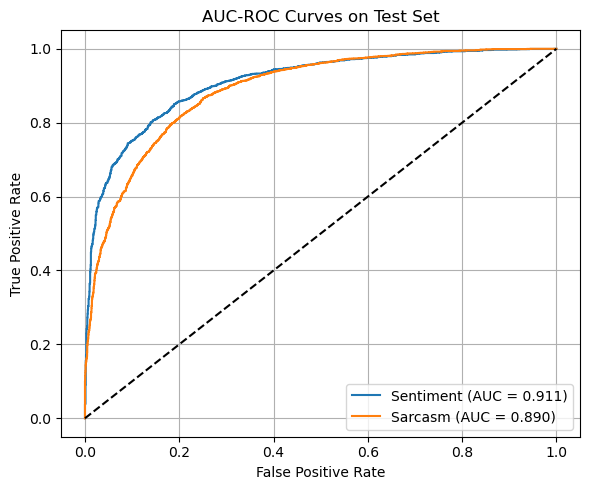


Test Set Evaluation
Sentiment -> Acc: 0.822 | F1: 0.825 | Prec: 0.872 | Rec: 0.783
Sarcasm   -> Acc: 0.807 | F1: 0.798 | Prec: 0.801 | Rec: 0.795


In [116]:
'''
This cell computes prediction probabilities on the test set for both sentiment and sarcasm.
It applies masking to skip missing labels, collects predicted scores and true labels,
calculates AUC scores, and plots ROC curves for both tasks.
Finally, it computes and prints accuracy, F1-score, precision, and recall.
'''

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

sent_probs = []
sent_labels = []

with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_input = X_test[i:i+batch_size]
        batch_sentiment = y_sent_test[i:i+batch_size]

        pred_sentiment, _ = model(batch_input)
        mask = batch_sentiment != -1
        if mask.sum() > 0:
            probs = torch.softmax(pred_sentiment[mask], dim=1)[:, 1]  
            sent_probs.extend(probs.tolist())
            sent_labels.extend(batch_sentiment[mask].tolist())


sarc_probs = []
sarc_labels = []

with torch.no_grad():
    for i in range(0, X_test.shape[0], batch_size):
        batch_input = X_test[i:i+batch_size]
        batch_sarcasm = y_sarc_test[i:i+batch_size]

        _, pred_sarcasm = model(batch_input)
        mask = batch_sarcasm != -1
        if mask.sum() > 0:
            probs = torch.sigmoid(pred_sarcasm[mask].view(-1))
            sarc_probs.extend(probs.tolist())
            sarc_labels.extend(batch_sarcasm[mask].tolist())

# draw AUC-ROC plot
fpr_sent, tpr_sent, _ = roc_curve(sent_labels, sent_probs)
fpr_sarc, tpr_sarc, _ = roc_curve(sarc_labels, sarc_probs)

auc_sent = roc_auc_score(sent_labels, sent_probs)
auc_sarc = roc_auc_score(sarc_labels, sarc_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr_sent, tpr_sent, label=f"Sentiment (AUC = {auc_sent:.3f})")
plt.plot(fpr_sarc, tpr_sarc, label=f"Sarcasm (AUC = {auc_sarc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC-ROC Curves on Test Set")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

sent_preds = [1 if p > 0.5 else 0 for p in sent_probs]
sarc_preds = [1 if p > 0.5 else 0 for p in sarc_probs]


sent_acc = accuracy_score(sent_labels, sent_preds)
sent_f1 = f1_score(sent_labels, sent_preds)
sent_prec = precision_score(sent_labels, sent_preds)
sent_rec = recall_score(sent_labels, sent_preds)

sarc_acc = accuracy_score(sarc_labels, sarc_preds)
sarc_f1 = f1_score(sarc_labels, sarc_preds)
sarc_prec = precision_score(sarc_labels, sarc_preds)
sarc_rec = recall_score(sarc_labels, sarc_preds)

print("\nTest Set Evaluation")
print(f"Sentiment -> Acc: {sent_acc:.3f} | F1: {sent_f1:.3f} | Prec: {sent_prec:.3f} | Rec: {sent_rec:.3f}")
print(f"Sarcasm   -> Acc: {sarc_acc:.3f} | F1: {sarc_f1:.3f} | Prec: {sarc_prec:.3f} | Rec: {sarc_rec:.3f}")